In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import solve_ivp, trapz
import os
import tqdm

In [2]:
import sys
sys.path.append('../..')

from systemidentification import twoConductanceEquations

In [3]:
%matplotlib notebook

# Define some library functions

In [4]:
def flow_sim(X0,
             flow_time,
             healing_time,
             domain_size,
             domain,
             samples_per_trajectory
             ):
    """
    Return a an integration history object.
    """
    
    sim = twoConductanceEquations.TwoCondEqnSim(N=domain_size, Iapp=domain)    
    f = twoConductanceEquations.TwoCondEqnSim(N=domain_size, Iapp=domain).diff
    
    # Use Scipy's RK45 integrator for the flow generation.
    history = sim.integrate(
                            X0,
                            t_span=[0, healing_time + flow_time * samples_per_trajectory],
                            method='RK45',
                            dense_output=True,
                            rtol=1e-5,
                            atol=1e-8
                           )
    
    return history
        
def data_generator(starting_points,
                   flow_time,
                   healing_time,
                   domain_size,
                   domain,
                   samples_per_trajectory
                   ):
    """
    Return a set of preflow X data, postflow Y data, and a list of the integration restults for each pair.
    """
    results = [flow_sim(X0, flow_time, healing_time, domain_size, domain, samples_per_trajectory) for X0 in tqdm.tqdm_notebook(starting_points)]

    X = np.empty((len(results) * samples_per_trajectory, domain_size, 2))
    Y = np.empty((len(results) * samples_per_trajectory, domain_size, 2))
    
    current_sample = 0
    for samp, result in enumerate(results):
        times = np.arange(samples_per_trajectory+1) * flow_time + healing_time
        states = result.sol(times)
        for i in range(samples_per_trajectory):
            UV0, UV1 = states[:, i], states[:, i+1]
            X[current_sample, :, :] = UV0.reshape([2, domain_size]).T
            Y[current_sample, :, :] = UV1.reshape([2, domain_size]).T
            current_sample += 1

    return (X, Y, results)

# Make a dataset
Generate a lot of short trajectories with the IC method from above.

In [5]:
## Set parameters for simulator.
domain_size = 128
domain = np.linspace(15, 24, domain_size)
dx = domain[1] - domain[0]

path = os.getcwd()
data_path = os.path.join(path, 'HH Data', 'Data Initialization')
os.makedirs(data_path, exist_ok=True)

def make_adjacency(neighbors):
    A = np.eye(domain_size, k=0)
    for i in range(1, neighbors+1):
        A += np.eye(domain_size, k=i) + np.eye(domain_size, k=-i)
    return A

A = make_adjacency(domain_size)

In [6]:
# Get an initial state on the limit cycle.
X0 = twoConductanceEquations.DataGenerator(N=domain_size, Iapp=domain, A=A, rtol=1e-5, atol=1e-8).simulator.history.y[:, -1]

# Find the period of the limit cycle.
def LC_section(t, y):
    return y[0] + 45

find_LC = LC_section
find_LC.direction = 1
LC_period_integration = twoConductanceEquations.TwoCondEqnSim(N=domain_size, Iapp=domain, A=A).integrate(X0, t_span=[0, 30], events=find_LC, rtol=1e-5, atol=1e-8)
LC_period = np.diff(LC_period_integration['t_events'][0])[-1]

In [7]:
# Use the initial state in a sampling simulation.
sim = twoConductanceEquations.TwoCondEqnSim(N=domain_size, Iapp=domain)

# Add a small correction factor (1.01) to make sure that the sampling covers the entire limit cycle.
t_sampling = [0, 1.01 * LC_period]
sim.integrate(X0=X0, t_span=t_sampling, dense_output=True, rtol=1e-5, atol=1e-8);

In [8]:
# Evaluate the simulation at n_evaluations equally spaced times in t_sampling. Use these evaluations to compute the
# 'speeds' of the oscillators (time derivatives), which are used to approximate the starting_point selection density.
# The goal is to sample more where the oscillators are fast and less where they are slow to get a sampling that
# is more uniform with regards to arc length.

# The number of evalutations used for the probability density approximation.
n_evaluations = 10000
t_eval = np.linspace(t_sampling[0], t_sampling[-1], n_evaluations)

# The number of samples to draw from the probability distribution, defines the number of starting_points returned.
nsamp = 10000

# Evaluate the simulation at n_evaluations times to approximate the 
testing_points = sim.history.sol(t_eval)
species_derivatives = np.empty((2 * domain_size, n_evaluations))
oscillator_speeds = np.empty((domain_size, n_evaluations))

# Find the time derivatives at every starting point.
for i in range(n_evaluations):
    species_derivatives[:, i] = sim.diff(None, testing_points[:, i])
    for j in range(domain_size):
        # Compute the speed of the oscillator from V and h of each sample.
        idx = [j, j + domain_size]
        oscillator_speeds[j, i] = np.linalg.norm(species_derivatives[idx, i])

# Use the 'speeds' to compute a probability density.
average_speeds = np.mean(oscillator_speeds, axis=0)
time_probability = average_speeds / np.sum(average_speeds)

# Sample the starting_points from the probabilty density.
starting_times = np.random.choice(t_eval, size=nsamp, p=time_probability)
starting_points = sim.history.sol(starting_times)
starting_points = np.transpose(starting_points.T.reshape((-1, 2, 128)), [0, 2, 1])

C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


<IPython.core.display.Javascript object>


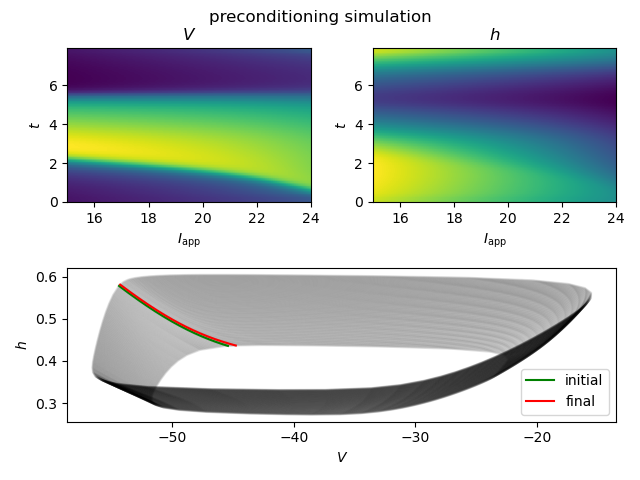

<IPython.core.display.Javascript object>


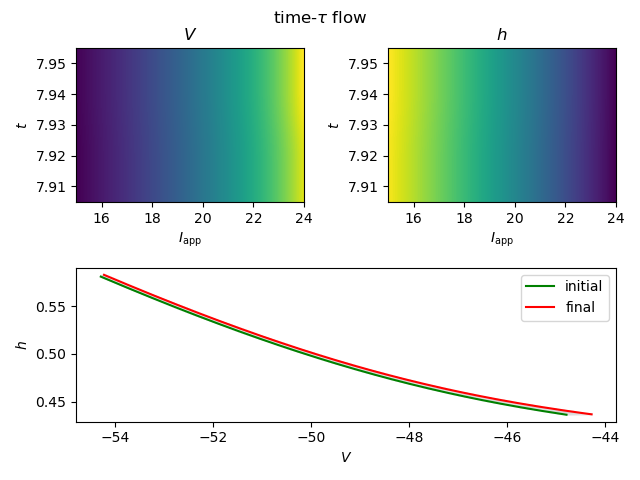

In [9]:
# Plot some initialization data.
X_pre, T_pre = sim.history.y, sim.history.t
X, Y, results = data_generator(starting_points=X_pre[:, -1][None, :],
                                                          flow_time=0.05,
                                                          healing_time=0,
                                                          domain_size=domain_size,
                                                          domain=domain,
                                                          samples_per_trajectory=1)

X_post, T_post = np.vstack((X[0, :, :].T.ravel(), Y[0, :, :].T.ravel())).T, np.vstack((T_pre[-1], T_pre[-1]+0.05)).T

for ((X, T), suptitle) in [((X_pre, T_pre), 'preconditioning simulation'), ((X_post, T_post), r'time-$\tau$ flow')]:
    fig = plt.figure()
    fig.suptitle(suptitle)

    Xr = X.T.reshape(T.size, 2, domain_size)

    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 1, 2)

    for ifocal, ax in enumerate([ax1, ax2]):
        ax.imshow(Xr[:, ifocal, :], aspect='auto', origin='lower', extent=[domain.min(), domain.max(), T.min(), T.max()])
        ax.set_xlabel(r'$I_\mathrm{app}$'); ax.set_ylabel('$t$'); ax.set_title('$%s$' % ('Vh'[ifocal],));
        ax.grid(False)

    ax3.plot(Xr[:, 0, :], Xr[:, 1, :], color='black', linestyle='-', alpha=.1)
    ax3.set_xlabel('$V$'); ax3.set_ylabel('$h$')
    ax3.plot(Xr[0, 0, :], Xr[0, 1, :], color='green', label='initial')
    ax3.plot(Xr[-1, 0, :], Xr[-1, 1, :], color='red', label='final')
    ax3.legend()
    ax3.grid(False);

    fig.tight_layout()
    fig.subplots_adjust(top=.9)

<IPython.core.display.Javascript object>


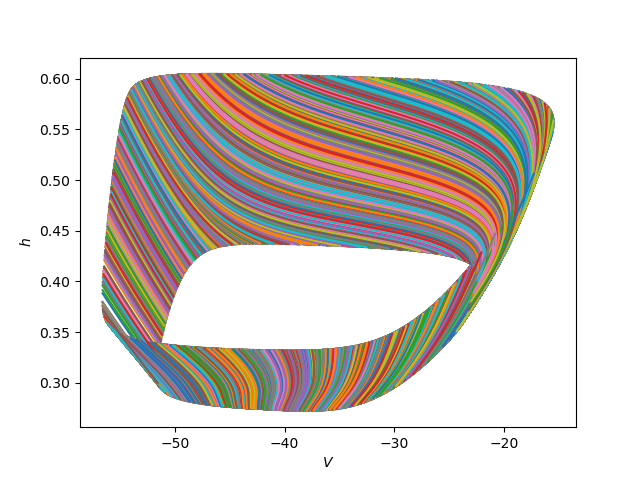

In [10]:
# Check the density of the evaluations.
fig, ax = plt.subplots()
ax.plot(starting_points[:, :, 0].T, starting_points[:, :, 1].T);
ax.set_xlabel('$V$');
ax.set_ylabel('$h$');

In [11]:
# np.savez(os.path.join(data_path, 'Initializations.npz'),
#          domain=domain,
#          adjacency_matrix=A,
#          X0=X0,
#          starting_points=starting_points,
#          starting_times=starting_times
#         )